# Speech Command Recognition 

This notebook presents an attention model for speech command recognotion. We use Google Speech Commands Dataset to test the Keras generator for sound files and the proposed RNN attention model.


## Download files and load information

Dynamically load speech data from the disk to allow handling big datasets.

First step: download Google Speech Command Dataset and convert all WAV files to numpy arrays for faster load (about 10x faster than loading raw WAV).

In [1]:
useColab=False
if useColab:
    %tensorflow_version 2.x
    !wget -q https://raw.githubusercontent.com/douglas125/SpeechCmdRecognition/master/SpeechDownloader.py
    !wget -q https://raw.githubusercontent.com/douglas125/SpeechCmdRecognition/master/SpeechGenerator.py
    !wget -q https://raw.githubusercontent.com/douglas125/SpeechCmdRecognition/master/audioUtils.py
    !wget -q https://raw.githubusercontent.com/douglas125/SpeechCmdRecognition/master/SpeechModels.py
    !wget -q https://raw.githubusercontent.com/douglas125/SpeechCmdRecognition/master/requirements.txt
    !pip install -r requirements.txt

In [2]:
import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5449092905005595708
xla_global_id: -1
]


In [3]:
#!pip install kapre

In [4]:
#%load_ext autoreload
#%autoreload 2

import librosa
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

import SpeechDownloader
import SpeechGenerator
#import SpeechModels
import audioUtils
import ColorSpeechModels
import ColorSpeechGenerator


In [5]:
# Download and prepare all data
#gscInfo, nCategs = SpeechDownloader.PrepareGoogleSpeechCmd(version=2, task='12cmd')

In [6]:
#nCategs

In [5]:
def _getFileCategory(file, catDict):
    """
    Receives a file with name sd_GSCmdV2/train/<cat>/<filename> and returns an integer that is catDict[cat]
    """
    categ = os.path.basename(os.path.dirname(file))
    return catDict.get(categ, 0)

In [6]:
#gscInfo=audioUtils.WAV2Numpy('one_sec_data')
audioUtils.WAV2Numpy('split_colour')

0it [00:00, ?it/s]


In [7]:
import os
basePath = 'split_colour'
TrainallWAVs=[]
for root, dirs, files in os.walk(basePath + '/train/'):
        TrainallWAVs += [root + '/' + f for f in files if f.endswith('.wav.npy')]

In [8]:
TestallWAVs=[]
for root, dirs, files in os.walk(basePath + '/test/'):
        TestallWAVs += [root + '/' + f for f in files if f.endswith('.wav.npy')]

In [10]:
ValidallWAVs=[]
for root, dirs, files in os.walk(basePath + '/validation/'):
        ValidallWAVs += [root + '/' + f for f in files if f.endswith('.wav.npy')]

In [11]:
#'unknown': 0,
#    'silence': 0,
#    '_unknown_': 0,
#    '_silence_': 0,
#    '_background_noise_': 0,
GSCmdV2Categs = {
    'akashi': 0,
    'badami': 1,
    'beguni': 2,
    'dhusor': 3,
    'golapi': 4,
    'holud': 5,
    'kalo': 6,
    'kamala': 7,
    'khoyeri': 8,
    'lal': 9,
    'neel': 10,
    'rupali': 11,
    'sada': 12,
    'sobuj': 13,
    'sonali': 14}
nCategs = 15

In [219]:
#GSCmdV2Categs = {
#    'unknown': 0,
#    'silence': 0,
#    '_unknown_': 0,
#    '_silence_': 0,
#    '_background_noise_': 0,
#    'zero': 1,
#     'one': 2}
#nCategs = 3

In [12]:
GSCmdV2Categs

{'akashi': 0,
 'badami': 1,
 'beguni': 2,
 'dhusor': 3,
 'golapi': 4,
 'holud': 5,
 'kalo': 6,
 'kamala': 7,
 'khoyeri': 8,
 'lal': 9,
 'neel': 10,
 'rupali': 11,
 'sada': 12,
 'sobuj': 13,
 'sonali': 14}

In [13]:
testWAVlabels = [_getFileCategory(f, GSCmdV2Categs) for f in TestallWAVs]
trainWAVlabels = [_getFileCategory(f, GSCmdV2Categs) for f in TrainallWAVs]
validWAVlabels = [_getFileCategory(f, GSCmdV2Categs) for f in ValidallWAVs]

In [45]:
#testWAVlabels[580]

In [14]:
testWAVlabelsDict = dict(zip(TestallWAVs, testWAVlabels))
trainWAVlabelsDict = dict(zip(TrainallWAVs, trainWAVlabels)) 
validWAVlabelsDict = dict(zip(ValidallWAVs, validWAVlabels)) 

In [15]:
trainInfo = {'files': TrainallWAVs, 'labels': trainWAVlabelsDict}
testInfo = {'files': TestallWAVs, 'labels': testWAVlabelsDict}
valInfo = {'files': ValidallWAVs, 'labels': validWAVlabelsDict}

In [16]:
gscInfo = {'train': trainInfo,
            'test': testInfo,
            'val': valInfo
           }
#'val': valInfo,testREAL': testREALInfo

In [21]:
#len(TestallWAVs)

In [22]:
#gscInfo

We should have 4 datasets, each with file names 'files' and their categories 'labels' in a dict.

In [17]:
print(gscInfo.keys())
print(gscInfo['train'].keys())
print(len(gscInfo['train']['files']))
print(len(gscInfo['test']['files']))
print(len(gscInfo['val']['files']))
#print((gscInfo['test']['labels']))
print(nCategs)

dict_keys(['train', 'test', 'val'])
dict_keys(['files', 'labels'])
11580
2481
2481
15


# Speech Data Generator

Use Keras to create a generator that reads files on the fly.

In [18]:
import ColorSpeechGeneratorSplit
sr = 16000 #we know this one for google audios
iLen = 32000
trainGen = ColorSpeechGeneratorSplit.SpeechGen(gscInfo['train']['files'], gscInfo['train']['labels'], shuffle=True)
# handle the fact that number of samples in validation may not be multiple of batch_size with shuffle=True
valGen   = ColorSpeechGeneratorSplit.SpeechGen(gscInfo['val']['files'], gscInfo['val']['labels'], shuffle=True)

# use batch_size = total number of files to read all test files at once
testGen  = ColorSpeechGeneratorSplit.SpeechGen(gscInfo['test']['files'], gscInfo['test']['labels'], shuffle=False, batch_size=len(gscInfo['test']['files']))
#testRGen = SpeechGenerator.SpeechGen(gscInfo['testREAL']['files'], gscInfo['testREAL']['labels'], shuffle=False, batch_size=len(gscInfo['testREAL']['files']))
valGen.__len__()

77

In [19]:
#testGen.__len__()

In [20]:
#trainGen

In [19]:
audios, classes = trainGen.__getitem__(0)
classes

array([ 9,  1,  0, 11, 13,  4,  6, 10,  7, 11, 13, 14,  9,  6,  9,  9,  0,
        0,  4,  1,  7,  6,  0, 12, 10, 12,  2, 10,  8, 11, 14,  6])

In [20]:
audios.shape


(32, 32000)

In [21]:
len(valGen)

77

Text(0.5, 0, 'Time')

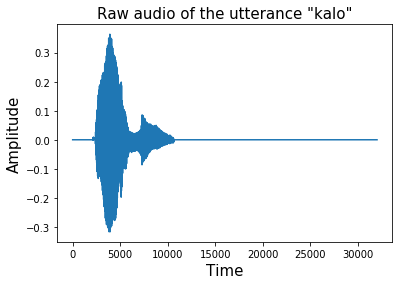

In [79]:
# librosa.output.write_wav('file.wav', audios[4], sr, norm=False)
plt.plot(audios[13])
plt.title('Raw audio of the utterance "kalo"', fontsize=15)
plt.ylabel('Amplitude', fontsize=15)
plt.xlabel('Time', fontsize=15)

In [76]:
import IPython.display as ipd
#samples, sample_rate = librosa.load(audios[14], sr = 16000)
#samples = librosa.resample(samples, sample_rate, 8000)
#ipd.Audio(samples,rate=16000) 
input_audio=np.array(audios[13])
import IPython.display as ipd
ipd.Audio(input_audio,rate=16000)

In [23]:
from tensorflow.keras.models import Sequential
from kapre.time_frequency import Melspectrogram, Spectrogram
from kapre.utils import Normalization2D

melspecModel = Sequential()

melspecModel.add(Melspectrogram(n_dft=1024, n_hop=128, input_shape=(1, iLen),
                         padding='same', sr=sr, n_mels=100,
                         fmin=40.0, fmax=sr/2, power_melgram=1.0,
                         return_decibel_melgram=True, trainable_fb=False,
                         trainable_kernel=False,
                         name='mel_stft') )

melspecModel.add(Normalization2D(int_axis=0))

melspecModel.summary()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the ver

In [24]:
melspec = melspecModel.predict( audios.reshape((-1,1,iLen)) )
melspec.shape

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(32, 100, 250, 1)

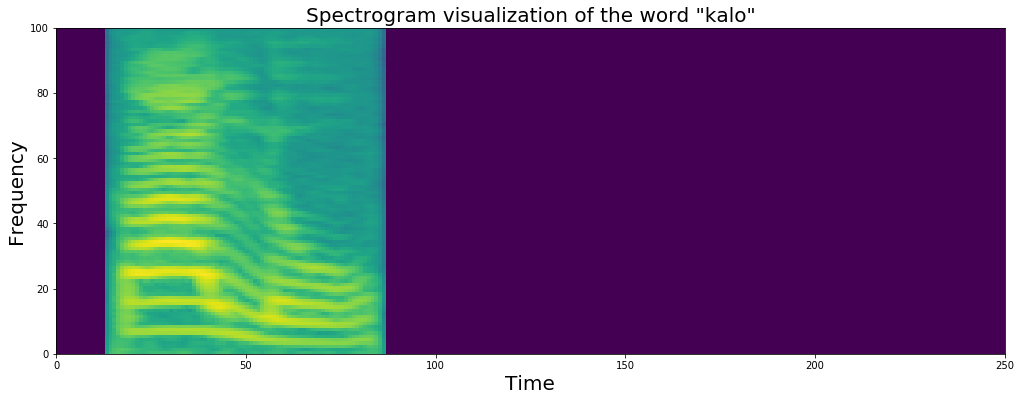

In [198]:
plt.figure(figsize=(17,6))
plt.pcolormesh(melspec[13,:,:,0])

plt.title('Spectrogram visualization of the word "kalo"', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.xlabel('Time', fontsize=20)

plt.show()

In [26]:
# Check if mel spectrogram matches the one computed with librosa
librosa_melspec = librosa.feature.melspectrogram(y=audios[14], sr=sr, n_fft=1024,
                                                 hop_length=128, power=1.0, #window='hann',
                                                 n_mels=100, fmin=40.0, fmax=sr/2)
S_dB = librosa.power_to_db(librosa_melspec, ref=np.max)

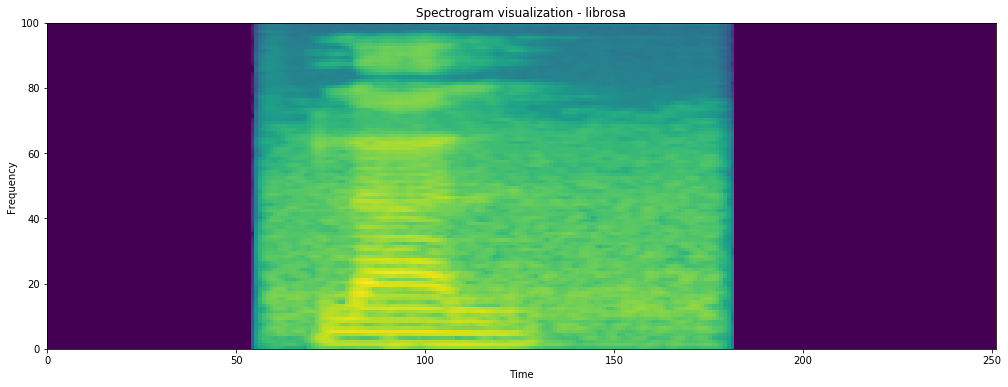

In [27]:
plt.figure(figsize=(17,6))
plt.pcolormesh(S_dB)

plt.title('Spectrogram visualization - librosa')
plt.ylabel('Frequency')
plt.xlabel('Time')

plt.show()

(array([4.0000e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        2.0000e+00, 2.0000e+00, 2.0000e+00, 6.0000e+00, 1.2050e+03,
        3.0000e+00, 9.0000e+00, 4.0000e+00, 7.0000e+00, 8.0000e+00,
        7.0000e+00, 1.0000e+00, 3.0000e+00, 7.0000e+00, 1.3000e+01,
        4.6000e+01, 8.3000e+01, 1.9000e+01, 2.4000e+01, 3.3000e+01,
        4.8000e+01, 2.8000e+01, 4.6000e+01, 3.1000e+01, 2.2000e+01,
        2.7000e+01, 5.5930e+03, 5.6000e+01, 7.3000e+01, 1.3415e+04,
        1.6277e+04, 7.7580e+03, 2.7336e+04, 2.1066e+04, 3.2995e+04,
        7.2462e+04, 1.3036e+04, 7.1366e+04, 1.5912e+04, 1.1080e+03,
        5.6092e+04, 1.3630e+03, 1.7420e+03, 2.5460e+03, 4.1120e+03,
        5.8690e+03, 8.1560e+03, 9.9880e+03, 8.9040e+03, 8.8610e+03,
        9.6050e+03, 1.0175e+04, 1.4614e+04, 2.1044e+04, 2.7215e+04,
        2.7191e+04, 2.8161e+04, 2.8914e+04, 3.03

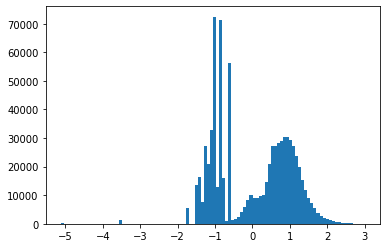

In [28]:
 plt.hist(melspec.flatten(), bins=100)

# Models

Create Keras models to see if the generators are working properly

In [29]:
from tensorflow.keras.models import Model, load_model

from kapre.time_frequency import Melspectrogram, Spectrogram

In [30]:
#import ColorSpeechModels
#self-attention LSTM
#nCategs=36
#sr=16000
#iLen=16000
#from keras import layers as L
from tensorflow.keras.models import Model, load_model

from tensorflow.keras import layers as L
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers

from kapre.time_frequency import Melspectrogram, Spectrogram
#composed_melgram_layer = kapre.composed.get_melspectrogram_layer(input_shape=(44100, 1))
from kapre.utils import Normalization2D

# simple LSTM
sr = 16000   #samplingrate
iLen = 32000 #inputLength
inputLength = 32000
nCategories = 15
rnn_func=L.LSTM
inputs = L.Input((inputLength,), name='input')

x = L.Reshape((1, -1))(inputs)

m = Melspectrogram(n_dft=1024, n_hop=128, input_shape=(1, iLen),
                       padding='same', sr=sr, n_mels=100,
                       fmin=40.0, fmax=sr / 2, power_melgram=1.0,
                       return_decibel_melgram=True, trainable_fb=False,
                       trainable_kernel=False,
                       name='mel_stft')
m.trainable = False

x = m(x)

x = Normalization2D(int_axis=0, name='mel_stft_norm')(x)

    # note that Melspectrogram puts the sequence in shape (batch_size, melDim, timeSteps, 1)
    # we would rather have it the other way around for LSTMs

x = L.Permute((2, 1, 3))(x)

x = L.Conv2D(5, (5, 2), activation='relu', padding='same')(x)
x = L.BatchNormalization()(x)
x = L.Conv2D(1, (5, 1), activation='relu', padding='same')(x)
x = L.BatchNormalization()(x)
x = L.Conv2D(1, (5, 1), activation='relu', padding='same')(x)
x = L.BatchNormalization()(x)
    # x = Reshape((125, 80)) (x)
    # keras.backend.squeeze(x, axis)
x = L.Lambda(lambda q: K.squeeze(q, -1), name='squeeze_last_dim')(x)

x = L.Bidirectional(L.LSTM(64, return_sequences=True))(x)
#x = L.BatchNormalization()(x)
x = L.Bidirectional(L.LSTM(32, return_sequences=True))(x)
#x = L.BatchNormalization()(x)
                        #)(x)  # [b_s, seq_len, vec_dim]
                        #)(x)  # [b_s, seq_len, vec_dim]
xFirst = L.Lambda(lambda q: q[:, -1])(x)  # [b_s, vec_dim]
query = L.Dense(64)(xFirst)

    # dot product attention
attScores = L.Dot(axes=[1, 2])([query, x])
attScores = L.Softmax(name='attSoftmax')(attScores)  # [b_s, seq_len]

    # rescale sequence
attVector = L.Dot(axes=[1, 1])([attScores, x])  # [b_s, vec_dim]

x = L.Dense(32, activation='relu')(attVector)
x = L.Dense(32)(x)

output = L.Dense(nCategories, activation='softmax', name='output')(x)

model = Model(inputs=[inputs], outputs=[output])



#model = ColorSpeechModels.AttRNNSpeechModel(nCategs, samplingrate = sr, inputLength = None)#, rnn_func=L.LSTM)

model.compile(optimizer='adam', loss=['sparse_categorical_crossentropy'], metrics=['sparse_categorical_accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 32000)]      0           []                               
                                                                                                  
 reshape (Reshape)              (None, 1, 32000)     0           ['input[0][0]']                  
                                                                                                  
 mel_stft (Melspectrogram)      (None, 100, 250, 1)  1101924     ['reshape[0][0]']                
                                                                                                  
 mel_stft_norm (Normalization2D  (None, 100, 250, 1)  0          ['mel_stft[0][0]']               
 )                                                                                            

In [90]:
#model.load_weights('model-attRNN.h5')

In [31]:
import math
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.4
    epochs_drop = 15.0
    lrate = initial_lrate * math.pow(drop,  
            math.floor((1+epoch)/epochs_drop))
    
    if (lrate < 4e-5):
        lrate = 4e-5
      
    print('Changing learning rate to {}'.format(lrate))
    return lrate
lrate = LearningRateScheduler(step_decay)

In [32]:
earlystopper = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=10,
                             verbose=1, restore_best_weights=True)
checkpointer = ModelCheckpoint('split_color_model_1-attLSTM.h5', monitor='val_sparse_categorical_accuracy', verbose=1, save_best_only=True)

results = model.fit(trainGen, validation_data=valGen, epochs=25, use_multiprocessing=False, workers=4, verbose=2,
                    callbacks=[earlystopper, checkpointer, lrate])

#model.save('model-attRNN.h5')

Changing learning rate to 0.001
Epoch 1/25
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to th

361/361 - 438s - loss: 0.0054 - sparse_categorical_accuracy: 0.9987 - val_loss: 0.0577 - val_sparse_categorical_accuracy: 0.9850 - lr: 4.0000e-04 - 438s/epoch - 1s/step
Changing learning rate to 0.0004
Epoch 22/25

Epoch 22: val_sparse_categorical_accuracy did not improve from 0.98701
361/361 - 444s - loss: 0.0073 - sparse_categorical_accuracy: 0.9980 - val_loss: 0.1250 - val_sparse_categorical_accuracy: 0.9752 - lr: 4.0000e-04 - 444s/epoch - 1s/step
Changing learning rate to 0.0004
Epoch 23/25

Epoch 23: val_sparse_categorical_accuracy did not improve from 0.98701
361/361 - 460s - loss: 0.0198 - sparse_categorical_accuracy: 0.9947 - val_loss: 0.1061 - val_sparse_categorical_accuracy: 0.9756 - lr: 4.0000e-04 - 460s/epoch - 1s/step
Changing learning rate to 0.0004
Epoch 24/25

Epoch 24: val_sparse_categorical_accuracy did not improve from 0.98701
361/361 - 445s - loss: 0.0033 - sparse_categorical_accuracy: 0.9993 - val_loss: 0.0593 - val_sparse_categorical_accuracy: 0.9870 - lr: 4.0000e

In [33]:
model.save('split_color_model_1-attLSTM.h5')

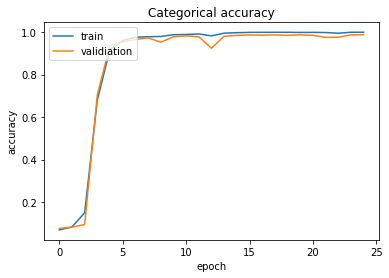

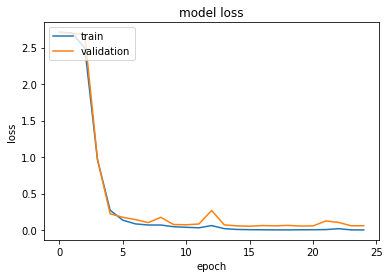

In [36]:
# summarize history for categorical accuracy
plt.plot(results.history['sparse_categorical_accuracy'])
plt.plot(results.history['val_sparse_categorical_accuracy'])
plt.title('Categorical accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validiation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [21]:
# results.history

In [81]:
#testGen=valGen
model.input.shape

TensorShape([None, 32000])

In [82]:
# load best model according to cross-validation - model-attRNN
# model = load_model('model-attRNN.h5', custom_objects={'Melspectrogram': Melspectrogram, 'Normalization2D': Normalization2D })
model.load_weights('split_color_model_1-attLSTM.h5')

In [83]:
#read all test data
x_test, y_test = testGen.__getitem__(0)

In [84]:
valEval = model.evaluate(valGen, use_multiprocessing=False, workers=4,verbose=0)
trainEval = model.evaluate(trainGen, use_multiprocessing=False, workers=4,verbose=0)
testEval = model.evaluate(x_test, y_test, verbose=0)
print('Evaluation scores: \nMetrics: {} \nTrain: {} \nValidation: {} \nTest: {}'.format(model.metrics_names, trainEval, valEval, testEval) )

Evaluation scores: 
Metrics: ['loss', 'sparse_categorical_accuracy'] 
Train: [0.002138378331437707, 0.9995671510696411] 
Validation: [0.060029104351997375, 0.9882305264472961] 
Test: [0.06519388407468796, 0.9895203709602356]


In [29]:
kaggle12cmd = False
if kaggle12cmd:
    #only for the Kaggle competition, 12-cmd
    x_testR, y_testR = testRGen.__getitem__(0)
    testREval = model.evaluate(x_testR, y_testR, verbose=1)
    print(testREval)
    testREval = model.evaluate(testRGen, use_multiprocessing=True, workers=4,verbose=1)
    print(testREval)

## Evaluation and Attention Plots

In [85]:
attSpeechModel = Model(inputs=model.input,
                                 outputs=[model.get_layer('output').output, 
                                          model.get_layer('attSoftmax').output,
                                          model.get_layer('mel_stft').output])


In [86]:
audios, classes = valGen.__getitem__(1)
classes

array([ 0,  6, 10,  3,  3,  5,  8,  7,  0,  6, 13, 10,  3,  4,  0,  1, 12,
        1,  9, 13, 13,  0,  5, 10,  7, 11,  6,  8,  0, 13,  3, 12])

In [87]:
#8 - on, 13 - one, 7 - right
idAudio = 20
classes[idAudio]

13

In [88]:
outs, attW, specs = attSpeechModel.predict(audios)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [89]:
np.argmax(outs,axis=1)

array([ 0,  6, 10,  3,  3,  5,  8,  7,  0,  6, 13, 10,  3,  4,  0,  1, 12,
        1,  9, 13, 13,  0,  5, 10,  7, 11,  6,  8,  0, 13,  3, 12],
      dtype=int64)

In [111]:
specs.shape
idAudio=25

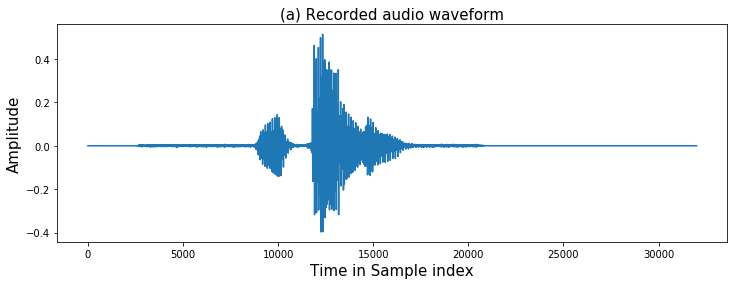

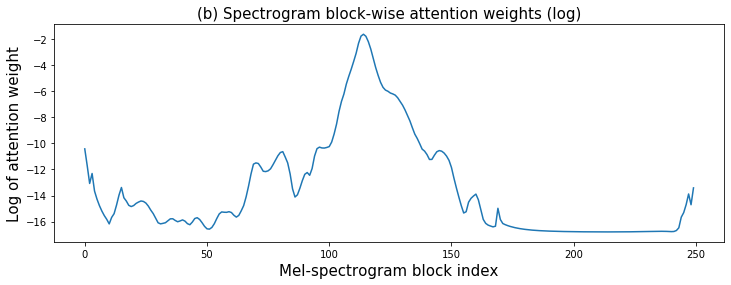

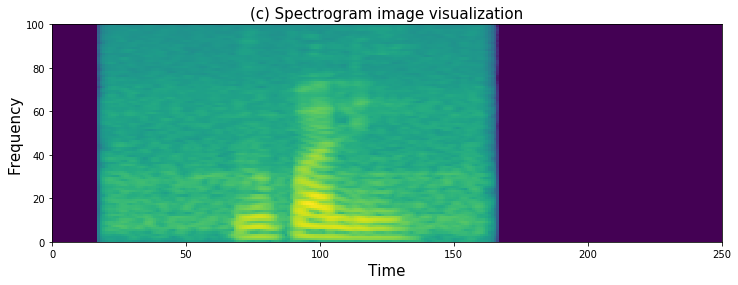

In [112]:
imgHeight = 4

plt.figure(figsize=(12,imgHeight))
plt.title('(a) Recorded audio waveform', fontsize=15)
plt.ylabel('Amplitude', fontsize=15)
plt.xlabel('Time in Sample index', fontsize=15)
plt.plot(audios[idAudio])
plt.savefig('picrawWave.png', dpi = 400)
plt.show()

plt.figure(figsize=(12,imgHeight))
plt.title('(b) Spectrogram block-wise attention weights (log)', fontsize=15)
plt.ylabel('Log of attention weight', fontsize=15)
plt.xlabel('Mel-spectrogram block index', fontsize=15)
plt.plot(np.log(attW[idAudio]))
plt.savefig('picAttention.png', dpi = 400)
plt.show()


plt.figure(figsize=(12,imgHeight))
plt.pcolormesh(specs[idAudio,:,:,0])

plt.title('(c) Spectrogram image visualization', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.xlabel('Time', fontsize=15)
plt.savefig('picmelSpec.png', dpi = 400)

plt.show()

In [113]:
y_pred = model.predict(x_test, verbose=1)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
78/78 [==============================] - 42s 474ms/step


In [114]:
from sklearn.metrics import confusion_matrix
import audioUtils
cm = confusion_matrix(y_test, np.argmax(y_pred,1))

In [35]:
#set(y_test)

In [115]:
#35word, v2
#classes = ['nine', 'yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go',
#           'zero', 'one', 'two', 'three', 'four', 'five', 'six', 
#           'seven',  'eight', 'backward', 'bed', 'bird', 'cat', 'dog',
#           'follow', 'forward', 'happy', 'house', 'learn', 'marvin', 'sheila', 'tree',
#           'visual', 'wow']
classes = ['akashi','badami','beguni','dhusor','golapi','holud','kalo','kamala','khoyeri','lal','neel','rupali','sada',
    'sobuj','sonali']

classes1 = ['আকাশী','বাদামি','বেগুনি','ধূসর','গোলাপি','হলুদ','কালো','কমলা','খয়রি','লাল','নীল','রুপালি','সাদা','সবুজ','সোনালী']     

In [171]:
len(classes)
classes[14]

'sonali'

In [37]:
#35word, v1
#classes=['nine', 'yes',  'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go',
#         'zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven',  'eight', 
#         'bed', 'bird', 'cat', 'dog', 'happy', 'house', 
#         'marvin', 'sheila', 'tree', 'wow']

In [38]:
#20cmd
#classes=['unknown', 'nine', 'yes',  'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go',
#         'zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven',  'eight']

Confusion matrix, without normalization


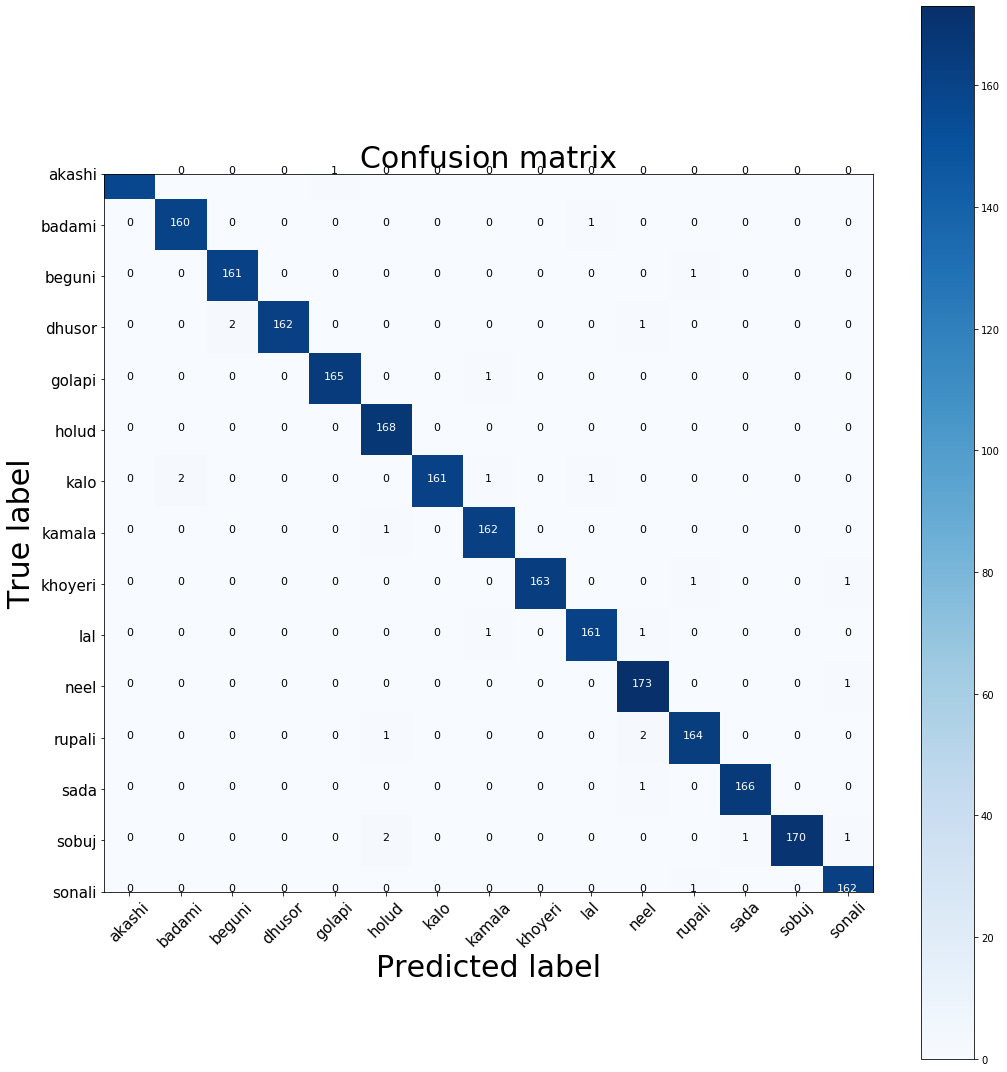

In [116]:
audioUtils.plot_confusion_matrix(cm, classes, normalize=False)

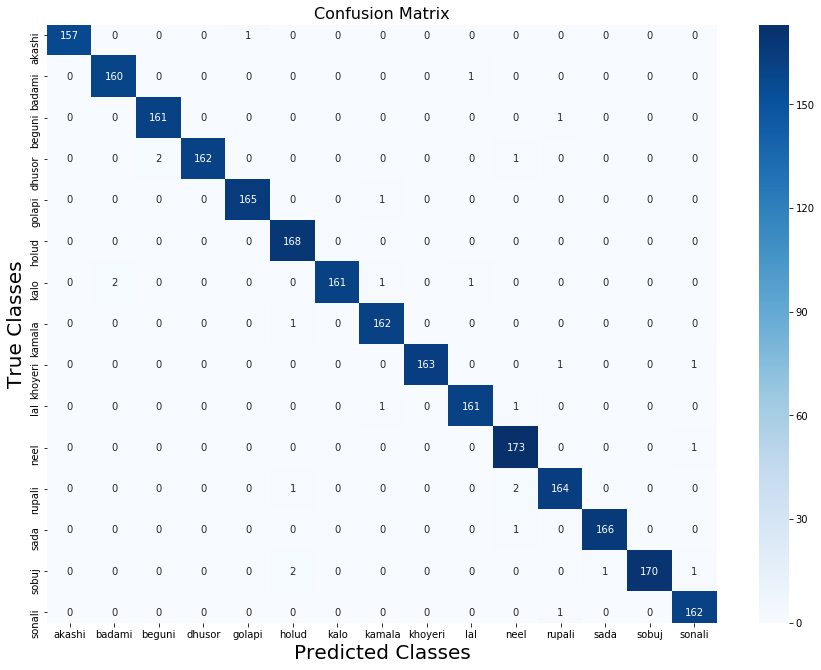

In [117]:
import seaborn as sn
import pandas as pd

df_cm = pd.DataFrame(np.array(cm), index = [i for i in classes],
                  columns = [i for i in classes])
#df_cm = someDataFrame.corr()
plt.figure(figsize = (15,11))
ax = sn.heatmap(df_cm, annot=True,fmt="d",cmap='Blues')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.25, top - 0.25)
plt.title("Confusion Matrix", fontsize=16)
plt.ylabel("True Classes"     , fontsize=20)
plt.xlabel("Predicted Classes", fontsize=20)
plt.show()

In [68]:
import pandas as pd
import kapre
[tf.__version__, kapre.__version__, pd.__version__, librosa.__version__]

['2.8.0', '0.2.0', '0.25.1', '0.9.1']

# Save model to .pb

In [118]:
#model = SpeechModels.AttRNNSpeechModel(nCategs, samplingrate = sr, inputLength = None)#, rnn_func=L.LSTM)
#model.load_weights('model-attRNN.h5')

model = load_model('split_color_model_1-attLSTM.h5', custom_objects={'Melspectrogram': Melspectrogram, 'Normalization2D': Normalization2D })

In [119]:
tf.saved_model.save(model, "attLSTMModel/color_split/")

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity t

INFO:tensorflow:Assets written to: attLSTMModel/color_split/assets


INFO:tensorflow:Assets written to: attLSTMModel/color_split/assets


In [120]:
import os
os.listdir('attLSTMModel/color_split/')

['assets', 'saved_model.pb', 'variables']

In [44]:
# if using tensorflow 1.x

In [121]:
# save model to pb ====================
def freeze_session(session, keep_var_names=None, output_names=None, clear_devices=True):
    """
    Freezes the state of a session into a pruned computation graph.
    Creates a new computation graph where variable nodes are replaced by
    constants taking their current value in the session. The new graph will be
    pruned so subgraphs that are not necessary to compute the requested
    outputs are removed.
    @param session The TensorFlow session to be frozen.
    @param keep_var_names A list of variable names that should not be frozen,
                          or None to freeze all the variables in the graph.
    @param output_names Names of the relevant graph outputs.
    @param clear_devices Remove the device directives from the graph for better portability.
    @return The frozen graph definition.
    """
    from tensorflow.python.framework.graph_util import convert_variables_to_constants
    graph = session.graph
    with graph.as_default():
        freeze_var_names = list(set(v.op.name for v in tf.global_variables()).difference(keep_var_names or []))
        output_names = output_names or []
        output_names += [v.op.name for v in tf.global_variables()]
        input_graph_def = graph.as_graph_def()
        if clear_devices:
            for node in input_graph_def.node:
                node.device = ""
        frozen_graph = convert_variables_to_constants(session, input_graph_def,
                                                      output_names, freeze_var_names)
        return frozen_graph



In [73]:
wkdir = ''
pb_filename = 'attLSTM.pb'

# save keras model as tf pb files ===============
sess = tf.compat.v1.keras.backend.get_session()

#frozen_graph = freeze_session(sess,
#                              output_names=[out.op.name for out in model.outputs])
#tf.train.write_graph(frozen_graph, wkdir, pb_filename, as_text=False)

In [145]:
import sounddevice as sd
import soundfile as sf

samplerate = 16000  
duration = 2 # seconds
filename = 'record_file.wav'
print("start")
mydata = sd.rec(int(samplerate * duration), samplerate=samplerate,
    channels=1, blocking=True)
print("end")
sd.wait()
sf.write(filename, mydata, samplerate)

start
end


Text(0.5, 0, 'Time')

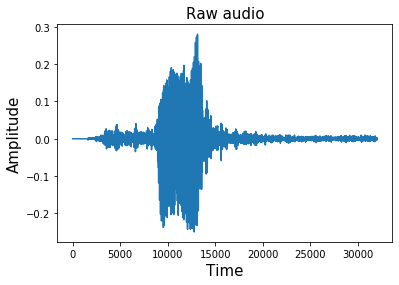

In [148]:
plt.plot(samples)
plt.title('Raw audio', fontsize=15)
plt.ylabel('Amplitude', fontsize=15)
plt.xlabel('Time', fontsize=15)

In [147]:
import IPython.display as ipd
samples, sample_rate = librosa.load(filename, sr = 16000)
#samples = librosa.resample(samples, sample_rate, 8000)
ipd.Audio(samples,rate=16000) 

In [183]:
input_audio=np.array(samples).reshape(1,32000)
import IPython.display as ipd
ipd.Audio(input_audio,rate=16000)
#input_audio.shape

In [97]:
pred = model.predict(input_audio, verbose=1)
index=np.argmax(pred)
classes1[index]

1/1 [==============================] - 0s 63ms/step


'গোলাপি'

In [78]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [122]:
import sounddevice as sd
import soundfile as sf

start
end
              গোলাপি


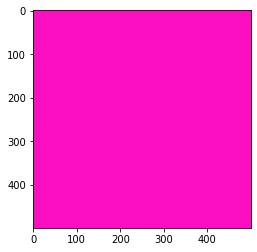

In [195]:
samplerate = 16000  
duration = 2 # seconds
filename = 'record_file.wav'
print("start")
mydata = sd.rec(int(samplerate * duration), samplerate=samplerate,
    channels=1, blocking=True)
print("end")
sd.wait()
sf.write(filename, mydata, samplerate)
samples, sample_rate = librosa.load(filename, sr = 16000)
input_audio=np.array(samples).reshape(1,32000)
pred = model.predict(input_audio, verbose=0)
index=np.argmax(pred)
classes1[index]
import matplotlib.pyplot as plt
import matplotlib.image as img
if index == 0:
    a=img.imread('./Colours_images/Akashi.jpg')
    plt.imshow(a)
elif index == 1:
    a=img.imread('./Colours_images/Badami.jpg')
    plt.imshow(a)
elif index == 2:
    a=img.imread('./Colours_images/Beguni.png')
    plt.imshow(a)
elif index == 3:
    a=img.imread('./Colours_images/Dhusor.jpg')
    plt.imshow(a)
elif index == 4:
    a=img.imread('./Colours_images/Golapi.jpg')
    plt.imshow(a)
elif index == 5:
    a=img.imread('./Colours_images/Holud.png')
    plt.imshow(a)
elif index == 6:
    a=img.imread('./Colours_images/Kalo.jpg')
    plt.imshow(a)
elif index == 7:
    a=img.imread('./Colours_images/Kamala.jpg')
    plt.imshow(a)
elif index == 8:
    a=img.imread('./Colours_images/Khoyeri.jpg')
    plt.imshow(a)
elif index == 9:
    a=img.imread('./Colours_images/Lal.jpg')
    plt.imshow(a)
elif index == 10:
    a=img.imread('./Colours_images/Neel.png')
    plt.imshow(a)
elif index == 11:
    a=img.imread('./Colours_images/Rupali.jpg')
    plt.imshow(a)
elif index == 12:
    a=img.imread('./Colours_images/Sada.png')
    plt.imshow(a)
elif index == 13:
    a=img.imread('./Colours_images/Sobuj.png')
    plt.imshow(a)
else:
    a=img.imread('./Colours_images/Sonali.jpg')
    plt.imshow(a)
    
print("             ",classes1[index])        

In [196]:
import IPython.display as ipd
ipd.Audio(input_audio,rate=16000)

Text(0.5, 0, 'Time')

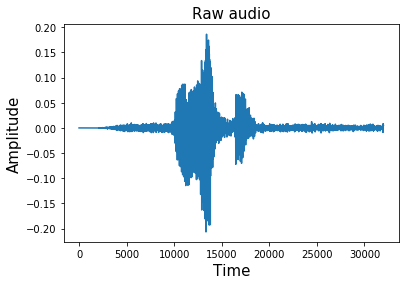

In [197]:
plt.plot(samples)
plt.title('Raw audio', fontsize=15)
plt.ylabel('Amplitude', fontsize=15)
plt.xlabel('Time', fontsize=15)

In [199]:
from sklearn.metrics import confusion_matrix
print(cm)

[[157   0   0   0   1   0   0   0   0   0   0   0   0   0   0]
 [  0 160   0   0   0   0   0   0   0   1   0   0   0   0   0]
 [  0   0 161   0   0   0   0   0   0   0   0   1   0   0   0]
 [  0   0   2 162   0   0   0   0   0   0   1   0   0   0   0]
 [  0   0   0   0 165   0   0   1   0   0   0   0   0   0   0]
 [  0   0   0   0   0 168   0   0   0   0   0   0   0   0   0]
 [  0   2   0   0   0   0 161   1   0   1   0   0   0   0   0]
 [  0   0   0   0   0   1   0 162   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0 163   0   0   1   0   0   1]
 [  0   0   0   0   0   0   0   1   0 161   1   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0 173   0   0   0   1]
 [  0   0   0   0   0   1   0   0   0   0   2 164   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   1   0 166   0   0]
 [  0   0   0   0   0   2   0   0   0   0   0   0   1 170   1]
 [  0   0   0   0   0   0   0   0   0   0   0   1   0   0 162]]


In [200]:
from sklearn.metrics import classification_report
print(classification_report(y_test,np.argmax(y_pred,1)))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       158
           1       0.99      0.99      0.99       161
           2       0.99      0.99      0.99       162
           3       1.00      0.98      0.99       165
           4       0.99      0.99      0.99       166
           5       0.98      1.00      0.99       168
           6       1.00      0.98      0.99       165
           7       0.98      0.99      0.99       163
           8       1.00      0.99      0.99       165
           9       0.99      0.99      0.99       163
          10       0.97      0.99      0.98       174
          11       0.98      0.98      0.98       167
          12       0.99      0.99      0.99       167
          13       1.00      0.98      0.99       174
          14       0.98      0.99      0.99       163

    accuracy                           0.99      2481
   macro avg       0.99      0.99      0.99      2481
weighted avg       0.99   

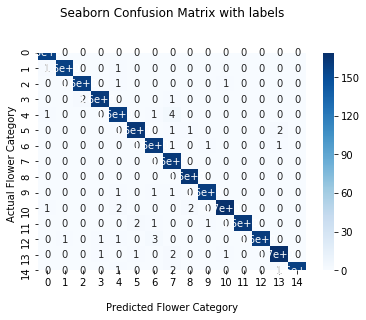

In [113]:
import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.heatmap(cm, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Flower Category')
ax.set_ylabel('Actual Flower Category ');

## Ticket labels - List must be in alphabetical order
#ax.xaxis.set_ticklabels(['Setosa','Versicolor', 'Virginia'])
#ax.yaxis.set_ticklabels(['Setosa','Versicolor', 'Virginia'])

## Display the visualization of the Confusion Matrix.
plt.show()

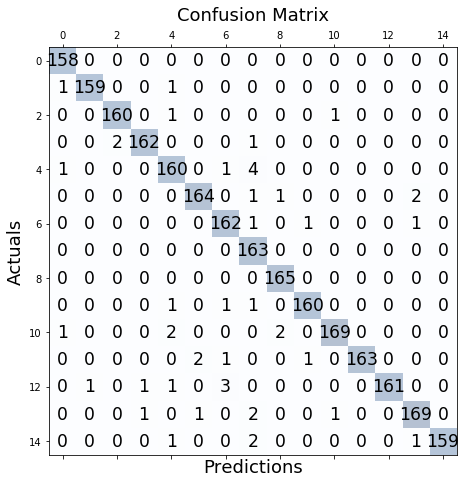

In [116]:
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()